In [ ]:
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.8 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [ ]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [ ]:
import spacy
spacy_en = spacy.load('en_core_web_sm')   # 영어 토큰화
spacy_de = spacy.load('de_core_news_sm')  # 독일어 토큰화

In [ ]:
# 간단히 토큰화(tokenization) 기능 써보기
tokenized = spacy_en.tokenizer("I am a graduate student.")

for i, token in enumerate(tokenized):
    print(f"인덱스 {i}: {token.text}")

인덱스 0: I
인덱스 1: am
인덱스 2: a
인덱스 3: graduate
인덱스 4: student
인덱스 5: .


In [ ]:
# 독일어(Deutsch) 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [ ]:
from torchtext.data import Field, BucketIterator

# Field 라이브러리 활용해서 데이터셋에 대한 구체적인 전처리 내용 명시
SRC = Field(tokenize=tokenize_de, init_token="", eos_token="", lower=True, batch_first=True) # 독일어
TRG = Field(tokenize=tokenize_en, init_token="", eos_token="", lower=True, batch_first=True) # 영어

In [ ]:
# 대표 영어-독어 번역 데이터셋 불러오기
from torchtext.datasets import Multi30k
train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".de", ".en"), fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 945kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 235kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 224kB/s]


In [ ]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


In [ ]:
# 학습 데이터 중 하나를 선택해 출력
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']


In [ ]:
# field 객체의 build_vocab 메서를 이용해 영어와 독어 단어사전 생성 (최소 2번 이상 등장한 단어만 사용)
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7852
len(TRG): 5892


In [ ]:
print(TRG.vocab.stoi["abcabc"]) # 없는 단어: 0
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1
print(TRG.vocab.stoi[""]) # : 2
print(TRG.vocab.stoi[""]) # : 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
2
4111
1751


In [ ]:
# 한 문장에 포함된 단어가 순서대로 나열된 상태로 네트워크에 입력되어야
## 따라서 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 만들면 좋음
## 이를 위해 BucketIterator를 사용
## 배치 크기(batch size): 128
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device)

In [ ]:
device

device(type='cuda')

In [ ]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 29])
인덱스 0: 2
인덱스 1: 4
인덱스 2: 567
인덱스 3: 10
인덱스 4: 356
인덱스 5: 1813
인덱스 6: 20
인덱스 7: 76
인덱스 8: 1820
인덱스 9: 8
인덱스 10: 2769
인덱스 11: 74
인덱스 12: 6
인덱스 13: 5
인덱스 14: 802
인덱스 15: 3
인덱스 16: 2
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1
인덱스 26: 1
인덱스 27: 1
인덱스 28: 1


## Packages and Modules

In [ ]:
# 필요한 패키지 불러오기
import torch
from torch import nn # neural network base class
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt

In [ ]:
# GPU 가속 확인
# print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
# print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True여야 함
# print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True여야 함
# # !python -c 'import platform;print(platform.platform())'

In [ ]:
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# print(device)

## 1. Embedding
token embedding(=input embedding)과 positional embedding으로 이루어져 있음

### (1) Token(=Input) Embedding
- dense representation of tokens
- input에 입력된 데이터를 행렬로 변환하는 과정 (=임베딩)
    - 트랜스포머 논문에서 각 토큰은 512차원으로 임베딩 됨


In [ ]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        '''
        vocab_size: size of vocab
        d_model: dimension of the model
        '''
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        # embedding에도 scaling 적용
        ## positional embedding값이 더해지면서 임베딩 벡터의 값이 희석되는 것을 막기 위함
        out = self.embedding(x) * math.sqrt(self.d_model)

        return out

### (2) Positional Embedding
- inject info about the position of the tokens in sequence   
=> compute sinusoid encoding
- RNN 계열의 모델은 입력된 문장을 순차적으로 처리하는 반면, 트랜스포머는 입력된 문장을 병렬로 한 번에 처리함   
=> 병렬로 처리함으로써 연산은 빨라지지만 토큰의 위치 혹은 순서를 알 수 없게 되어 위치 정보를 별도로 넣어줘야 함

[주의점]
1. 모든 위치 값은 sequence의 길이에 상관없이 동일한 식별자를 가져야 함 (sequence 내용이 바뀌어도 임베딩 값이 같아야 함)
2. 모든 위치 값은 너무 크면 안됨 (단어 의미 정보 변질: 단어 간 상관관계나 의미를 유추할 수 있는 정보의 중요도가 상대적으로 작아지게 되어 제대로 된 학습이 되지 않을 수 있음)   
=> sequence 크기에 비례하여 일정하게 커지는 정수값 부여, normalization 적용 등은 이러한 이유 때문에 사용 불가능   
=> sinusoid encoding 활용!!
    - sine, cosine은 -1과 1을 사이를 반복하는 주기함수 (값이 너무 커지지 않음)
    - 그러나 위치 벡터 값이 같아지는 문제 발생할 수 있음 (예를 들어, 포지션 0과 포지션 n에서 sine 값이 같다면)
        => 따라서 sine과 cosine 동시에 사용

> PE_(pos, 2i) = sin(pos/10000^{2i/d_model})
> PE_(pos, 2i+1) = cos(pos/10000^{2i/d_model})

#### Positional Encoding 시각화
https://github.com/jalammar/jalammar.github.io/blob/master/notebookes/transformer/transformer_positional_encoding_graph.ipynb

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return pos_encoding


(1, 10, 512)


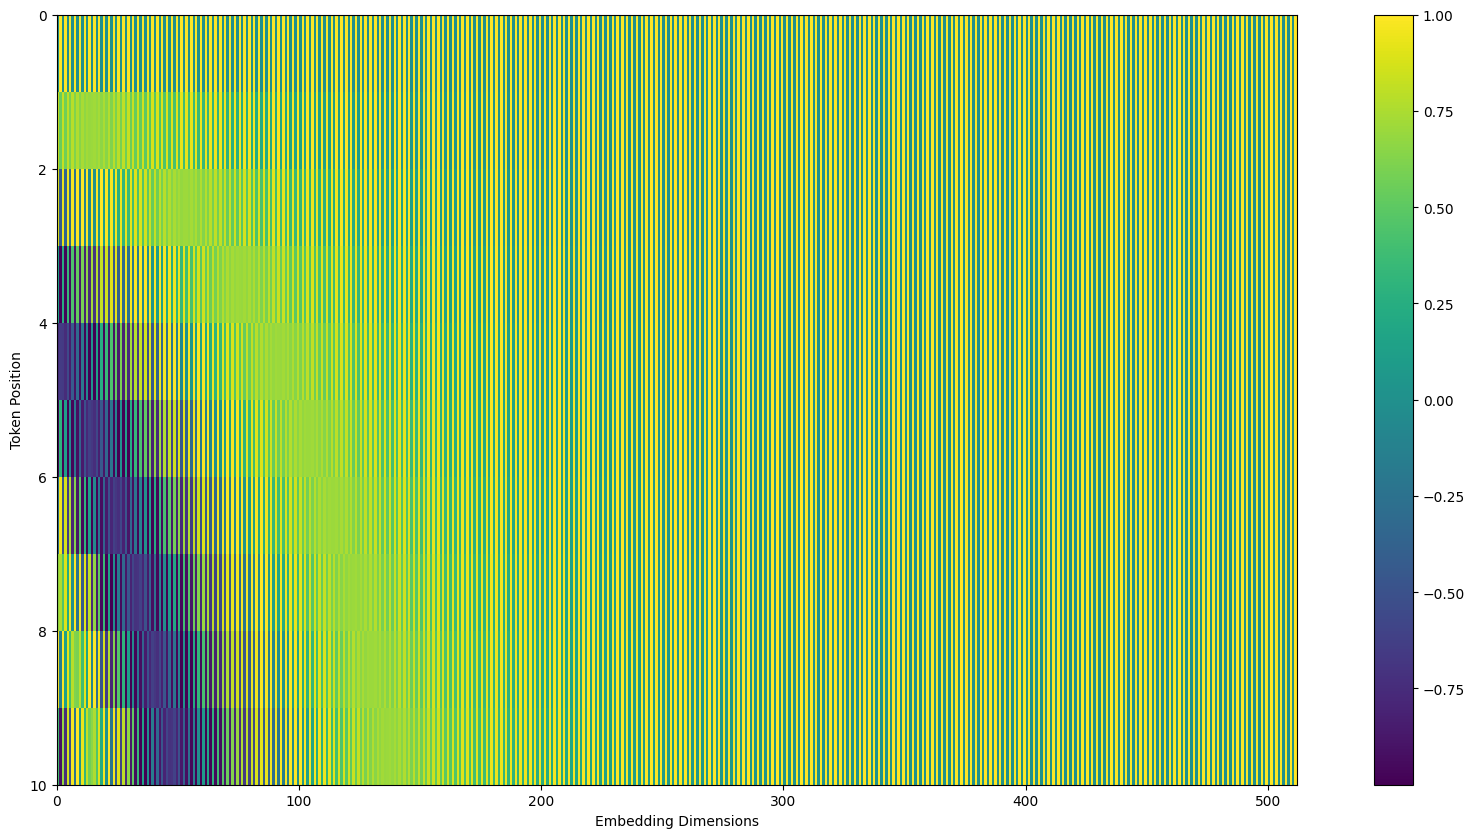

In [ ]:
tokens = 10         # 10개 단어
dimensions = 512    # 512 차원

pos_encoding = positional_encoding(tokens, dimensions)
print (pos_encoding.shape)

plt.figure(figsize=(20,10))
plt.pcolormesh(pos_encoding[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, dimensions))
plt.ylim((tokens,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

#### Positional Embedding 코드

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model, device):
        '''
        max_len: max length of sequence
        d_model: dimension of the model
        device: setting
        '''
        super().__init__()
        # 비어 있는 텐서 생성
        self.PE = torch.zeros(max_len, d_model, device=device)
        # no need to compute gradient (학습되는 값이 아님, 공식에 의해 계산됨)
        self.PE.requires_grad = False

        pos = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(dim=1)
        for_2i = torch.arange(0, d_model, step=2, dtype=torch.float, device=device)

        # 문장 길이가 달라져도 단어 사이 거리를 보존할 수 있는 sinusoid 사용
        ## PE_(pos,2i)는 단어 pos의 position embedding vector의 위치 2i의 원소값을 의미
        self.PE[:, 0::2] = torch.sin(pos / (10000 ** (for_2i / d_model))) # 2i가 짝수인 경우
        self.PE[:, 1::2] = torch.cos(pos / (10000 ** (for_2i / d_model))) # 2i가 홀수인 경우


    def forward(self, x):
        _, seq_len = x.size()

        return self.PE[:seq_len, :] # input의 length에 맞춰서 positional encoding 결과 반환

In [ ]:
# torch.arange(0, 3).unsqueeze(dim=1)
# torch.arange(0, 6).shape

### (3) Embedding (token+positional)
- token embedding과 positional embedding을 summation해서 사용
- 왜 concat하지 않았을까?  

[concatenation]
- token 내용은 자체 차원 공간을 갖게 되고, positional 정보 또한 자체 차원 공간을 갖게 되어 둘은 서로 관계 없는 공간에 위치하게 됨
- 이점: 정보가 뒤섞이지 않음
- 문제: 메모리, 파라미터, 런타임 등에 관련된 비용 문제 발생

[summation]
- 이점: token 내용과 position 정보의 균형을 잘 맞출 수 있음 (벡터 공간에서 단어 의미 정보와 위치 정보 간의 거리 적절하게 유지)
- 문제: 정보 뒤섞일 수 있음

=> GPU 등 하드웨어 성능 좋으면 concat 해서 사용해도 괜찮을지도

In [ ]:
class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, device):
        super().__init__()
        self.tok_emb = TokenEmbedding(vocab_size, d_model)
        self.pos_emb = PositionalEmbedding(max_len, d_model, device)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(x)
        out = self.dropout(tok_emb + pos_emb)

        return out

## 2. Sub-layers
multi-head attention   
    -  scaled dot-product attention   
position-wise fully connected feed-forward network

<center><img src="https://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png" height="300" width="300"></center>

### (1) Scaled Dot-Product Attention
> Attention(Q, K, V) = softmax(QK^T/(d_k)**0.5)V

[순서]
1. Transpose K   
2. MatMul of Q and K^T => attention score   
3. scale (for stable gradients)   
4. (mask to -inf if necessary)   
5. apply softmax => 가중치 도출 (determines how much each word will be expressed at this position)    
6. MatMul of attention result and V (the intuition here is to keep intact the values of word(s) we want to focus on, and drown-out irrelevant words (by multiplying small weights))   

<center> <img src="https://raw.githubusercontent.com/angiekim05/study/master/Paper_Code_Practice/Transformer/src/scaled_dot_product_attention.png" width="200" height="270"> </center>

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1) # apply softmax to the last dimension
        self.dropout = nn.Dropout(0.1)

    def forward(self, q, k, v, mask=None):
        # 4D tensor as input: [batch_size, n_heads, seq_len, head_dim]
        _, _, _, head_dim = k.size()

        # transpose K
        k_t = k.transpose(2, 3)

        # matmul of Q and K^T + scale
        ## Q @ K^T = [batch_size, n_heads, q_seq_len, k_seq_len]
        score = torch.matmul(q, k_t) / math.sqrt(head_dim)

        # masking (opt.)
        ## torch.tensor.masked_fill(): 텐서의 특정 값을 다른 값으로 바꾸고자 할 때 사용
        ## mask: 단어가 있는 곳(True), 마스킹 되어 단어가 없는 곳(False, 0)
        if mask is not None:
            score = score.masked_fill(mask==0, -10000000000) # mask가 0인 경우 -inf로 채움 (softmax 계산 시 0이 되게끔)

        # apply softmax (weight)
        ## score = [batch_size, n_heads, q_seq_len, k_seq_len]
        score = self.softmax(score)
        # score = self.dropout(score)

        # multiply with Value (weighted sum)
        ## result = [batch_size, n_heads, seq_len, head_dim] (k, v는 seq_len이 같음)
        result = torch.matmul(score, v)

        return result, score

### (2) Multi-head Attention
단일 attention을 사용할 때보다 multi-head attention을 사용했을 때 문장의 특징 정보를 더 많이 잡을 수 있음
> Q, K, V 행렬(d_model=512차원)을 head의 수(8개)만큼 나누어서 진행(64차원)   
> head는 scaled dot-product attention   

[순서]
1. Q, K, V 행렬을 64차원으로 projection (linear(fc) 통과)
2. h=8로 분리
3. scaled dot-product attention 수행 (scaled dot-product att 8개가 하나의 attention이 되는 구조)
4. head concat (512차원)
5. projection (성능향상 목적)   
=> 각 단어에 대해 최종 512차원 벡터 반환

<center>
<img src="https://raw.githubusercontent.com/angiekim05/study/master/Paper_Code_Practice/Transformer/src/multi_head_attention.png" width="220" height="270">
</center>

<center><img src="https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/transformer.png" height="450" width="750"></center>

<center><img src="https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" width="700" height="450"></center>

In [ ]:
class MultiHeadAttention(nn.Module):
    # 사용될 구성 정의
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model              # 512
        self.n_heads = n_heads              # 8
        self.head_dim = d_model // n_heads  # 64

        # nn.Linear(in,out): input size와 output size 입력
        ## 논문의 설명에서는 seq_len * head_dim의 크기로 Q, K, V를 구해서 각각 attention을 계산하여 concat하는 방식을 쓰지만
        ## 별개의 attention 연산을 head회 수행해야 한다는 점에서 매우 비효율적
        ## 따라서, 실제로는 seq_len * d_model로 한 번의 attention 계산으로 처리
        ##
        self.w_q = nn.Linear(d_model, n_heads * self.head_dim, bias=False)
        self.w_k = nn.Linear(d_model, n_heads * self.head_dim, bias=False)
        self.w_v = nn.Linear(d_model, n_heads * self.head_dim, bias=False)
        self.w_o = nn.Linear(n_heads * self.head_dim, d_model, bias=False)
        self.attention = ScaledDotProductAttention()

        self.dropout = nn.Dropout(0.1)


    # 실행 계산 정의 (구성 연결)
    def forward(self, query, key, value, mask=None):
        # shape: [batch_size, seq_len, d_model]
        batch_size, _, _ = query.shape
        # apply weight matrices (=projection)
        q, k, v = self.w_q(query), self.w_k(key), self.w_v(value)

        # split into heads
        ## shape: [batch_size, n_heads, seq_len, head_dim]으로
        ## seq_len=-1로 설정하는 이유는 decoder 단에서는 q와 k, v의 seq_len이 다를 수 있기 때문
        q = q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

        # apply scaled dot-product attention
        att_result, attention_score = self.attention(q, k, v, mask=mask)

        # concat and pass to next layer (=Linear)
        ## att_result = [batch_size, n_heads, seq_len, head_dim]
        att_result = att_result.transpose(1, 2) # [batch_size, seq_len, n_heads, head_dim]
        att_result = att_result.contiguous().view(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        att_result = self.w_o(att_result) # [batch_size, seq_len, d_model]

        return att_result



### (3) Position-wise Fully Connected Feed Forward Network
- applied to each position separately and identically (병렬 가능)
- linear transformations + ReLU + linear transformation 구조
- FFN(x) = max(0, xW_1 + b_1) W_2 + b_2

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        # inner-layer dimensionality: d_ff = 2048
        # input and output dimensionality: d_model = 512
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)

        return x

### (4) Layer Normalization
- 각 샘플에 대해서 feature들에 대한 평균과 분산 구해서 정규화
- = nn.LayerNorm

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super().__init__()
        # nn.Parameter는 파라미터로 지정하고 싶은 tensor일 때 사용
        self.gamma = nn.Parameter(torch.ones(d_model)) # weight
        self.beta = nn.Parameter(torch.zeros(d_model)) # bias
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True) # keepdim: 차원유지 (broadcasting 가능하게끔)
        var = x.var(-1, unbiased=False, keepdim=True) # unbiased: calculate variance w/o Bessel's correction

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta

        return out

## 3. Blocks

### (1) Encoder Block
<center><img src="https://yangoos57.github.io/static/6e332ac57f0ed3147513504101b18da5/3c492/encoder_block_0.png" width="400" height="400"/></center>

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, d_ff, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads)
        self.dropout1 = nn.Dropout(0.1)
        self.norm1 = LayerNorm(d_model=d_model)

        self.ffn = PositionWiseFeedForward(d_model=d_model, d_ff=d_ff)
        self.dropout2 = nn.Dropout(0.1)
        self.norm2 = LayerNorm(d_model=d_model)


    def forward(self, x, padding_mask):
        '''
        x: [batch_size, seq_len, d_model]
        padding_mask: [batch_size, 1, 1, seq_len]
        '''

        # FIRST SUBLAYER
        _x = x
        # q, k, v는 표현만 다를 뿐, input 동일하게 사용
        ## mask, so that attention is not applied to pad tokens
        x = self.attention(query=x, key=x, value=x, mask=padding_mask)
        # "apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized"
        x = self.dropout1(x)
        x = self.norm1(x + _x) # x + _x: Residual Connection
        # => output: 512 dimension

        # SECOND SUBLAYER
        _x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        # => output: 512 dimension

        return x # => output: 512 dimension

### (2) Encoder
<center><img src="https://yangoos57.github.io/static/dd5c378de3e1a44105474c8c9c08dad9/3c492/encoder.png" width="450" height="400"></center>

In [ ]:
class Encoder(nn.Module):
    def __init__(self, enc_vocab_size, max_len, d_model, d_ff, n_heads, n_layers, device):
        super().__init__()
        # input
        self.emb = TransformerEmbedding(d_model=d_model,
                                        max_len=max_len,
                                        vocab_size=enc_vocab_size,
                                        device=device)
        # 6 encoder blocks
        ## nn.ModuleList: nn.Sequential과 유사하지만 nn.Sequential은 자동으로, 순차적으로 forward 메소드가 실행되기 때문에 한 단위로 실행되지만
        ##                nn.ModuleList의 경우 for문을 통해 iterate 하면서 리스트 내의 모듈을 각각 수행시키는 것
        self.layers = nn.ModuleList([EncoderBlock(d_model=d_model, d_ff=d_ff, n_heads=n_heads)
                                    for _ in range(n_layers)])

    def forward(self, x, padding_mask):
        '''
        x: [batch_size, seq_len]
        padding_mask: [batch_size, 1, 1, seq_len]
        '''

        # compute vector (sentence -> vector)
        x = self.emb(x)

        for layer in self.layers:
            x = layer(x, padding_mask)

        return x # => 인코더의 최종 결과값은 context (디코더에서 key와 value로 활용됨)

### (3) Decoder Block
<center><img src="https://yangoos57.github.io/static/5f18ca895d929c0c6041572c5e302c65/3c492/decoder_block_3.png" width="500" height="400"></center>

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, d_ff, n_heads):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads)
        self.norm1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(0.1)

        self.enc_dec_att = MultiHeadAttention(d_model=d_model, n_heads=n_heads)
        self.norm2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(0.1)

        self.ffn = PositionWiseFeedForward(d_model=d_model, d_ff=d_ff)
        self.norm3 = LayerNorm(d_model=d_model)
        self.dropout3 = nn.Dropout(0.1)

    def forward(self, dec, context, no_look_mask, padding_mask):
        '''
        dec: [batch_size, seq_len]
        context: [batch_size, seq_len, d_model]
        no_look_mask: [batch_size, 1, trg_len, trg_len]
        padding_mask: [batch_size, 1, 1, src_len]
        '''

        _x = dec
        # masked multi-head attention (mask=pad masking+subsequent masking)
        ## to prevent positions from attending to subsequent positions
        ## => ensures that the predictions for position i can depend only on the known outputs at positions less than i
        x = self.self_attention(query=dec, key=dec, value=dec, mask=no_look_mask)
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        if context is not None:
            _x = x
            # query: decoder attention의 결과 (예: 영어), key/value: encoder 결과 (예: 한국어)
            x = self.enc_dec_att(query=x, key=context, value=context, mask=padding_mask)
            x = self.dropout2(x)
            x = self.norm2(x + _x)

        _x = x
        x = self.ffn(x)
        x = self.dropout3(x)
        x = self.norm3(x + _x)

        return x

### (4) Decoder
<center><img src="https://yangoos57.github.io/static/9667d3a95db46e5f57616e57958c1061/3c492/decoder_1.png" width="600" height="500"></center>

decoder에 encoder의 output 외에 추가적으로 들어오는 input sentence
- teacher forcing을 위함
    - 모델 학스브 초창기에는 잘못된 token을 생성해낼 가능성이 큰데 이 잘못 예측된 token으로 다음 token도 예측하게 되면 제대로 된 학습이 진행되기 어려울 것
    - 따라서, ground truth를 추가적으로 입력해주어 사용하는 것

<center><img src="https://cpm0722.github.io/assets/images/2021-01-28-Transformer-in-pytorch/decoder.png" height="200" width="700"></center>

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dec_voc_size, max_len, d_model, d_ff, n_heads, n_layers, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        max_len=max_len,
                                        vocab_size=dec_voc_size,
                                        device=device)

        self.layers = nn.ModuleList([DecoderBlock(d_model=d_model,
                                                  d_ff=d_ff,
                                                  n_heads=n_heads)
                                     for _ in range(n_layers)])

    def forward(self, x, context, no_look_mask, padding_mask):
        x = self.emb(x)

        for layer in self.layers:
            x = layer(x, context, no_look_mask, padding_mask)


        return x

## 4. Transformer

<center><img src="https://yangoos57.github.io/static/94719d02225cd94f0b1c085d1e741291/6af66/img11.png" width="350" height="500"></center>

masking
- (seq_len X seq_len) 크기의 mask matrix를 곱하는 방식으로 이루어짐
- mask matrix에서 pad token에 해당하는 행과 열의 값은 0 (나머지는 1)
- 반드시 Q와 K의 행렬곱 적용 이후, softmax 적용 전 수행되어야 함

In [ ]:
class Transformer(nn.Module):
    def __init__(self, pad_idx, no_look_idx, enc_voc_size, dec_voc_size, d_model, n_heads, max_len,
                d_ff, n_layers, device):
        super().__init__()
        self.pad_idx = pad_idx
        self.no_look_idx = no_look_idx
        self.device = device
        self.encoder = Encoder(d_model=d_model,
                               n_heads=n_heads,
                               max_len=max_len,
                               d_ff=d_ff,
                               enc_voc_size=enc_voc_size,
                               n_layers=n_layers,
                               device=device)

        self.decoder = Decoder(d_model=d_model,
                               n_heads=n_heads,
                               max_len=max_len,
                               d_ff=d_ff,
                               dec_voc_size=dec_voc_size,
                               n_layers=n_layers,
                               device=device)

        self.generator = nn.Linear(d_model, dec_voc_size)

    def make_pad_mask(self, src):
        # src: [batch_size, seq_len]
        pad_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2) # pad_idx와 일치하지 않는 토큰은 모두 0, 그 외는 모두 1인 mask 생성
        # pad_mask: [batch_size, 1, 1, seq_len]
        return pad_mask

    def make_no_look_mask(self, trg):
        # trg: [batch_size, seq_len]
        pad_mask = (trg != self.no_look_idx).unsqueeze(1).unsqueeze(3)
        # pad_mask: [batch_size, 1, 1, seq_len]
        trg_len = trg.shape[1]
        sub_mask = torch.tril(torch.ones(trg_len, trg_len)).type(torch.ByteTensor).to(device) # lower triangle
        # sub_mask: [seq_len, trg_len]
        no_look_mask = pad_mask & sub_mask
        # no_look_mask: [batch_size, 1, trg_len, trg_len]
        return no_look_mask

    def forward(self, src, trg):
        padding_mask = self.make_pad_mask(src)
        trg_mask = self.make_no_look_mask(trg)

        context = self.encoder(src, padding_mask)
        output = self.decoder(trg, context, trg_mask, padding_mask) # output: [batch_size, seq_len, d_model]

        out = self.generator(output) # out: [batch_size, seq_len], 실제 token sequence를 원함, d_model을 len(vocab)으로 바꾸어주는 작업
        out = F.log_softmax(out, dim=-1) # 마지막 dimension인 len에 대한 확률값을 구해야 하기 때문, 성능 향상 위해 log_softmax 사용

        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self, pad_idx, no_look_idx, encoder, decoder, dec_voc_size, d_model,device):
        super().__init__()
        self.pad_idx = pad_idx
        self.no_look_idx = no_look_idx
        self.device = device
        self.encoder = encoder
        self.decoder = decoder

        self.generator = nn.Linear(d_model, dec_voc_size)

    def make_pad_mask(self, src):
        # src: [batch_size, seq_len]
        pad_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2) # pad_idx와 일치하지 않는 토큰은 모두 0, 그 외는 모두 1인 mask 생성
        # pad_mask: [batch_size, 1, 1, seq_len]
        return pad_mask

    def make_no_look_mask(self, trg):
        # trg: [batch_size, seq_len]
        pad_mask = (trg != self.no_look_idx).unsqueeze(1).unsqueeze(3)
        # pad_mask: [batch_size, 1, 1, seq_len]
        trg_len = trg.shape[1]
        sub_mask = torch.tril(torch.ones(trg_len, trg_len)).type(torch.ByteTensor).to(device) # lower triangle
        # sub_mask: [seq_len, trg_len]
        no_look_mask = pad_mask & sub_mask
        # no_look_mask: [batch_size, 1, trg_len, trg_len]
        return no_look_mask

    def forward(self, src, trg):
        padding_mask = self.make_pad_mask(src)
        trg_mask = self.make_no_look_mask(trg)

        context = self.encoder(src, padding_mask)
        output = self.decoder(trg, context, trg_mask, padding_mask) # output: [batch_size, seq_len, d_model]

        out = self.generator(output) # out: [batch_size, seq_len], 실제 token sequence를 원함, d_model을 len(vocab)으로 바꾸어주는 작업
        out = F.log_softmax(out, dim=-1) # 마지막 dimension인 len에 대한 확률값을 구해야 하기 때문, 성능 향상 위해 log_softmax 사용

        return out

In [ ]:
# torch.tril(torch.ones(10, 10))

## 학습(Training)

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
MODEL_DIM = 128
N_LAYERS = 2
N_HEADS = 2
FF_DIM = 258

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, 100, MODEL_DIM, N_LAYERS, N_HEADS, FF_DIM, device)
dec = Decoder(OUTPUT_DIM, 100, MODEL_DIM, FF_DIM, N_HEADS, N_LAYERS, device)

# Transformer 객체 선언
model = Transformer(SRC_PAD_IDX, TRG_PAD_IDX, enc,dec,OUTPUT_DIM, MODEL_DIM,device).to(device)

In [ ]:
# SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
# TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# # 인코더(encoder)와 디코더(decoder) 객체 선언
# enc = Encoder(INPUT_DIM, 100, MODEL_DIM, N_LAYERS, N_HEADS, FF_DIM, device)
# dec = Decoder(OUTPUT_DIM, 100, MODEL_DIM, FF_DIM, N_HEADS, N_LAYERS, device)

# # Transformer 객체 선언
# model = Transformer(SRC_PAD_IDX, TRG_PAD_IDX, INPUT_DIM, OUTPUT_DIM, MODEL_DIM,
#                     N_HEADS, 100, FF_DIM, N_LAYERS, device)

In [ ]:
# 가중치 초기화
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,121,868 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (emb): TransformerEmbedding(
      (tok_emb): TokenEmbedding(
        (embedding): Embedding(7852, 128)
      )
      (pos_emb): PositionalEmbedding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-257): 258 x EncoderBlock(
        (attention): MultiHeadAttention(
          (w_q): Linear(in_features=128, out_features=128, bias=False)
          (w_k): Linear(in_features=128, out_features=128, bias=False)
          (w_v): Linear(in_features=128, out_features=128, bias=False)
          (w_o): Linear(in_features=128, out_features=128, bias=False)
          (attention): ScaledDotProductAttention(
            (softmax): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm()
        (ffn): PositionWiseFeedForward(
          (linear1): Linear(in_featur

In [ ]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src.to(device)
        trg = batch.trg.to(device)

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스()는 제외
        # 입력을 할 때는 부터 시작하도록 처리
        output = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0()은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 출력 단어의 마지막 인덱스()는 제외
            # 입력을 할 때는 부터 시작하도록 처리
            output = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0()은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
# 학습(training) 및 검증(validation) 진행
## 학습 횟수(epoch): 10

import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 3m 56s
	Train Loss: 3.776 | Train PPL: 43.642
	Validation Loss: 3.513 | Validation PPL: 33.561
Epoch: 02 | Time: 3m 52s
	Train Loss: 3.526 | Train PPL: 33.986
	Validation Loss: 3.369 | Validation PPL: 29.051
Epoch: 03 | Time: 3m 52s
	Train Loss: 3.369 | Train PPL: 29.061
	Validation Loss: 3.285 | Validation PPL: 26.722
Epoch: 04 | Time: 3m 49s
	Train Loss: 3.252 | Train PPL: 25.840
	Validation Loss: 3.218 | Validation PPL: 24.970
Epoch: 05 | Time: 3m 47s
	Train Loss: 3.159 | Train PPL: 23.555
	Validation Loss: 3.207 | Validation PPL: 24.700
Epoch: 06 | Time: 3m 47s
	Train Loss: 3.077 | Train PPL: 21.697
	Validation Loss: 3.219 | Validation PPL: 25.011
Epoch: 07 | Time: 3m 58s
	Train Loss: 3.002 | Train PPL: 20.131
	Validation Loss: 3.251 | Validation PPL: 25.811
Epoch: 08 | Time: 4m 2s
	Train Loss: 2.939 | Train PPL: 18.906
	Validation Loss: 3.286 | Validation PPL: 26.740
Epoch: 09 | Time: 3m 51s
	Train Loss: 2.882 | Train PPL: 17.841
	Validation Loss: 3.330 | Validat

In [ ]:
# # 학습된 모델 저장
# from google.colab import files

# files.download('transformer_german_to_english.pt')

In [ ]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 3.197 | Test PPL: 24.449


In [ ]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=100, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에  토큰, 마지막에  토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_pad_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는  토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_no_look_mask(trg_tensor)

        with torch.no_grad():
            output = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # 를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 는 제외하고 출력 문장 반환
    return trg_tokens[1:]


In [ ]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
전체 소스 토큰: ['', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '']
소스 문장 인덱스: [2, 7, 363, 9, 133, 69, 623, 564, 18, 779, 199, 19, 87, 3, 2]
모델 출력 결과: hat talking woman dogs person into boy into boy into boy into boy into jacket building building front building front front front front front front front front front front front front front front front front front front front front front front front front front front front front front front front front front front front front front front front down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down down


[References]
- https://yangoos57.github.io/blog/DeepLearning/paper/Transformer/Transformer_From_Scratch/
- https://jalammar.github.io/illustrated-transformer/
- https://github.com/tunz/transformer-pytorch/blob/master/model/transformer.py
- https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb
- https://www.blossominkyung.com/deeplearning/transfomer-positional-encoding
- https://github.com/hyunwoongko/transformer/tree/master
- https://code-angie.tistory.com/7
- https://cpm0722.github.io/pytorch-implementation/transformer
- https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Attention_is_All_You_Need_Tutorial_(German_English).ipynb
